# Bayesian regression for storm erosion prediction
Joshua Simmons 05/2022

Further ideas:
 - https://nbviewer.org/github/pyro-ppl/numpyro/blob/master/notebooks/source/bayesian_regression.ipynb

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%pdb 1
%matplotlib inline

Automatic pdb calling has been turned ON


## Imports and settings

In [2]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az

from ipywidgets import interactive, fixed, widgets

# MAP regression
import sklearn.linear_model as lm

#numpyro
from jax import random
import jax.numpy as jnp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive

# plotting
from functions import (plot_regression, plot_pareto_points, draw_fit) 
# data
from functions import(load_shoreline_data, load_wave_data, clean_dshoreline_data) 
# analysis
from functions import (find_pareto_front,generate_storm_dataset)
# models
from functions import (linear_model)



## Load the data
Choose the transect name from [the coastsat website](http://coastsat.wrl.unsw.edu.au).
We will need:
- Wave data - to calculate storm energy. If this is not previously downloaded, we will fetch from ERA5
- Shoreline data - to calculate shoreline change between storms
- Storm dataset - using the wave and shoreline data, create a dataset for each storm event which has an associated energy (E) and shoreline change (dshl)


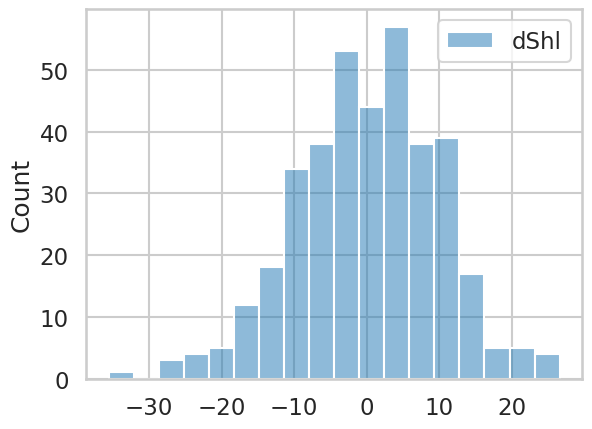

In [3]:
transect_name = 'aus0206-0005'
raw_shl_data = load_shoreline_data(transect_name=transect_name)
raw_wave_data = load_wave_data(transect_name=transect_name)
shl_data = generate_storm_dataset(raw_shl_data, raw_wave_data)

# Check the dsitribution with a quick hist plot
diff_shl_data = raw_shl_data.diff()
diff_shl_data.columns = ['dShl'] 
sns.histplot(diff_shl_data.dropna())
None

## Clean the storm dataset
The reality of this data is that it is quite noisy and really we are taking a very simplistic approach to modelling it. So to make life easier for ourselves, we will clean the data to try and find the equivalent of the barless conditions in the Harley 2009 paper.

![Source: Harley 2009](img/Harley2009_fit.png)
Source: Harley 2009

As such we will look for the Pareto front which defines the 

We will need to choose:
- paretoThresh: the threshold for distance from the Pareto front to be considered a valid storm event
- timeThresh: the maximum time between pre- and post- storm surveys to avoid problems due to low availability of satellite data
- energyThresh: the minimum energy to be considered a valid event

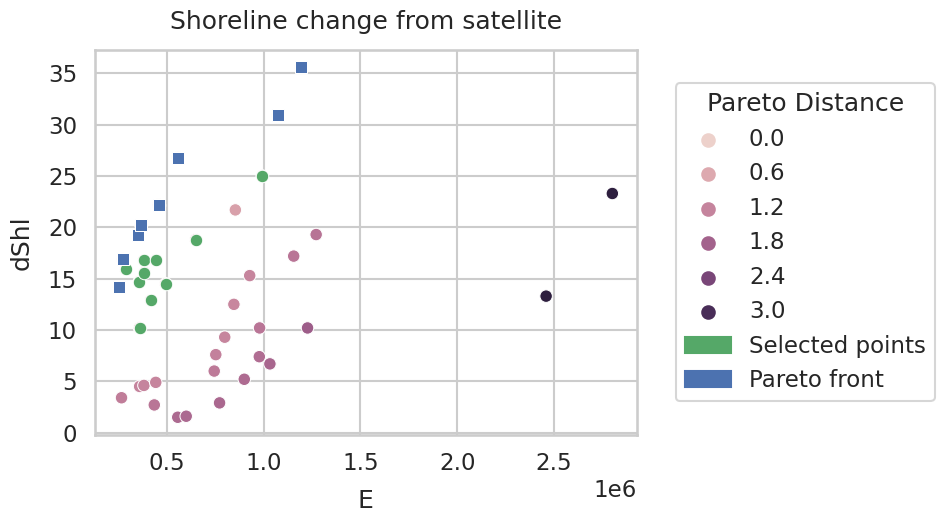

In [28]:
paretoThresh = 0.75
timeThresh = 100
energyThresh = 0.25e6

x, y, plotData = clean_dshoreline_data(shl_data, paretoThresh, timeThresh, energyThresh)

x_log = np.log(x)
y_log = np.log(y)

log_scale=False
plot_pareto_points(plotData,pareto_thresh=paretoThresh)
None

## Fit a Bayesian Linear Regression in logspace - MAP

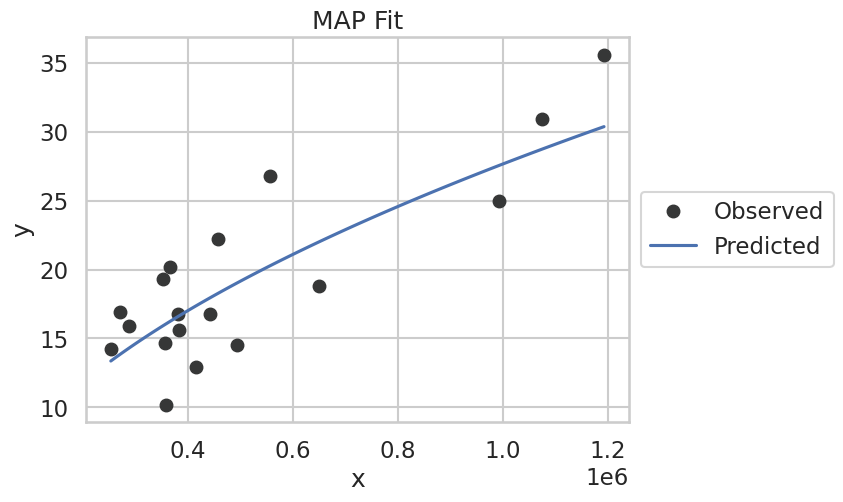

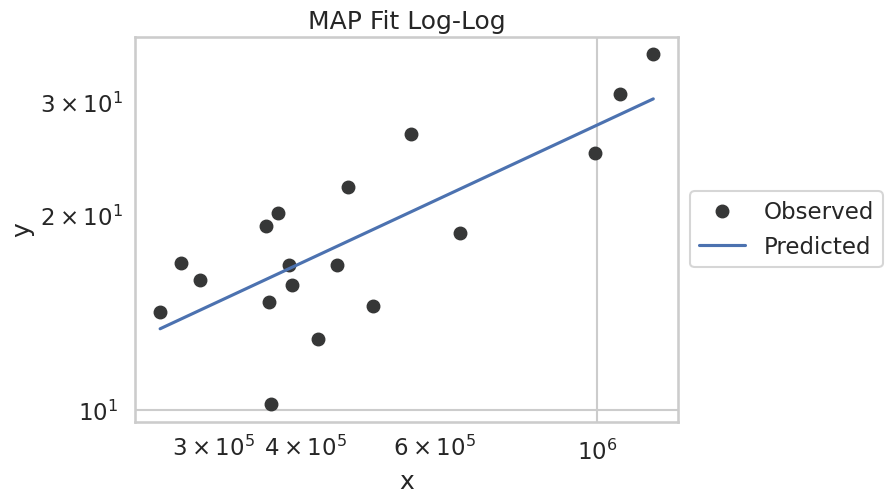

In [14]:
# fit a linear model to the data
model = lm.LinearRegression()
model.fit(x_log.reshape(-1,1),y_log)

sample_x = np.linspace(x.min(),x.max(),101)

y_pred = model.predict(np.log(sample_x).reshape(-1,1))

draw_fit(x,y,sample_x,np.exp(y_pred),title='MAP Fit')

draw_fit(x,y,sample_x,np.exp(y_pred),log_scale=True,title='MAP Fit Log-Log')
None

## Fit with numpryo

In [ ]:
def linear_model(energy=None,dshl=None):
    '''
    Define linear model with priors for the parameters and model error
    Need to check that the assumptions for priors give the right posterior
    '''
    # Define priors
    coeff1 = numpyro.sample("coeff1",dist.Gamma(0.5, 0.25))
    intercept = numpyro.sample("intercept",dist.Normal(0, 2))
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    mu_out = coeff1 * energy + intercept
    dshl_modelled = numpyro.sample("dshl_modelled", dist.Normal(mu_out, sigma), obs=dshl)

In [ ]:
# settings 
num_samples = 10000
burnin = int(0.25 * num_samples)
ci = 0.95

# Random number generator - jax style
rng_key = random.PRNGKey(2022)
rng_key, rng_key_ = random.split(rng_key)

# define the sampler
kernel = NUTS(linear_model)

# define the mcmc wrapper
mcmc_obj = MCMC(kernel, num_warmup=burnin, num_samples=num_samples)

mcmc_obj.run(
    rng_key_, energy=x_log, dshl=y_log
)
mcmc_obj.print_summary()
samples = mcmc_obj.get_samples()

In [ ]:
posterior_predictive = Predictive(linear_model, samples)(
    rng_key_, energy=x_log)

# predictions =  posterior_predictive(rng_key_, energy=x_log)["dshl_modelled"]
prior = Predictive(linear_model, num_samples=10)(
    rng_key_, energy=x_log #, dshl=y_log
)

prior_mu = (
    jnp.expand_dims(prior["intercept"], -1)
    + jnp.expand_dims(prior["coeff1"], -1) * x_log
)

numpyro_data = az.from_numpyro(
    mcmc_obj,
    prior=prior,
    posterior_predictive=posterior_predictive,
    # coords={"school": np.arange(eight_school_data["J"])},
    # dims={"theta": ["school"]},
)
numpyro_data
# az.plot_trace(numpyro_data,figsize=(10,7))
# None

In [ ]:
aa = az.plot_trace(numpyro_data,figsize=(10,7))


In [ ]:
posterior_predictive['dshl_modelled'].shape

In [ ]:
plt.plot(
    np.tile(x_log,(prior_mu.shape[0],1)).T,
    prior_mu.T
)
plt.title('prior')

In [ ]:
plt.scatter(
    np.tile(x_log,(posterior_predictive['dshl_modelled'].shape[0],1)),
    posterior_predictive['dshl_modelled']
)
plt.title('Posterior')

In [ ]:
x_log_out = np.linspace(x_log.min(),x_log.max()+(x_log.max()-x_log.min())*0.25,100)

# Compute empirical posterior distribution over mu
posterior_mu = (
    jnp.expand_dims(samples["intercept"], -1)
    + jnp.expand_dims(samples["coeff1"], -1) * x_log_out
)

sim_y = Predictive(linear_model, samples)(
    rng_key_, energy=x_log_out)['dshl_modelled']

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, ci)
hpdi_sim_y = hpdi(sim_y, ci)

ax = plot_regression(np.exp(x_log), np.exp(y_log), np.exp(x_log_out), np.exp(mean_mu), np.exp(hpdi_mu), np.exp(hpdi_sim_y), log_scale=True)
ax.set(
    xlabel="Energy", ylabel="dShl", title="Regression line with 95% CI"
)
ax = plot_regression(np.exp(x_log), np.exp(y_log), np.exp(x_log_out), np.exp(mean_mu), np.exp(hpdi_mu), np.exp(hpdi_sim_y))
ax.set(
    xlabel="Energy", ylabel="dShl", title="Regression line with 95% CI"
)
None